# **Names:** \_\_\_\_\_

**EIDs:** \_\_\_\_\_

**Kaggle Team Name:** \_\_\_\_\_

# CS4487 - Course Project

Due date: Nov 30, 11:59pm

## Goal

The course project is the following:

### Predicting outcomes of schizophrenia patient

> The goal is to predict the 12-year outcomes of patients with schizophernia using 3-years of data collected after the first diagnosed episode.  The dataset contains two prediction tasks: 1) predict Suicide death within 12 year time-span; 2) predict treatment resistance to antipsychotic medication (if a patient becomes resistant to medication, than another medication Clozapine is prescribed). A good prediction model would help create early treatment models to identify potential future problems.

> There are two types of data: 1) cross-sectional data consists of patient measurements taken at a specific time point (12 years after the first diagnosis); 2) longitidual data consists of 3 years of measurements after the first episode.  For this problem, the cross-sectional data contains the class we want to predict.  The longitudinal data contains baseline information and monthly reports of symptoms and functioning for the first 3 years.


You only need to select one of these tasks (mortality or treatment resistance) for the course project. 

<span style="color:red">_**NOTE: This dataset is provided by the Psychiatry department HKU and contains some sensitive and propietary information. Do NOT redistribute this dataset to other people.**_</span>


## Groups
Projects should be done in Groups of 2.  To sign up for a group, go to Canvas and under "People", join one of the existing "Project Groups".  _For group projects, the project report must state the percentage contribution from each project member._

## Methodology
You are free to choose the methodology to solve the task.  In machine learning, it is important to use domain knowledge to help solve the problem.  Hence, instead of blindly applying the algorithms to the data you need to think about how to represent the data in a way that makes sense for the algorithm to solve the task. 


## Evaluation on Kaggle

The final evaluation will be performed on Kaggle. See the below code about the evaluation procedure.

**Note:** You can only submit 2 times per day to Kaggle!

## Project Presentation

Each project group needs to give a presentation at the end of the semester.  The presentation time is 8 minutes.  You _must_ give a presentation.

## What to hand in
You need to turn in the following things:

1. This ipynb file `CourseProject-2018.ipynb` with your source code and documentation. **You should write about all the various attempts that you make to find a good solution.**
2. Your final submission file to Kaggle.
3. The ipynb file `CourseProject-2018-final.ipynb`, which contains the code that generates the final submission file that you submit to Kaggle. **This code will be used to verify that your Kaggle submission is reproducible.**
4. Presentation slides.

Files should be uploaded to "Course Project" on Canvas.


## Grading
The marks of the assignment are distributed as follows:
- 40% - Results using various feature representations, dimensionality reduction methods, classifiers, etc.
- 20% - Trying out feature representations (e.g. adding/engineering additional features, combining features, time-series features) or methods not used in the tutorials.
- 15% - Quality of the written report.  More points for insightful observations and analysis.
- 15% - Project presentation
- 10% - Final ranking on the Kaggle test data (private leaderboard).

**Late Penalty:** 25 marks will be subtracted for each day late.

<hr>

## Getting started

The following code will get you started reading in the datasets, train a baseline classifier and evaluate it.

In [199]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import pandas as pd

## Load data

The zip file contains the following files:
  - **Mortality prediction task**
    - `mortality/mortality_suicide.csv` - class labels (suicide).
    - `mortality/mortality_baseline.csv` - longitudinal data.
    - `mortality/mortality_baseline_vars.csv` - descriptions of the baseline variables.
    - `mortality/mortality_training.csv` - indices for training sets for 10 experiment trials.
    - `mortality/mortality_testing.csv` - indices for test sets for 10 experiment trials.
  - **Treatment Resistance prediction task**
    - `treatres/clozapine_tr.csv` - class label (treatment resistance).
    - `treatres/clozapine_baseline.csv` - longitudinal data.
    - `treatres/clozapine_baseline_vars.csv` - descriptions of the baseline variables
    - `treatres/treatres_training.csv` - indices for training sets for 10 experiment trials.
    - `treatres/treatres_testing.csv` - indices for testing sets for 10 experiment trials


In [200]:
# Set this variable according to the task you will do.
#   True=suicide data, False=treatment resistance data
doMortality = False

Now load the data files, join the tables according to subject ID.

In [201]:
# codes for "Missing Values", which are convereted to nan
na_values = [777, 888, 999, '777', '888', '999']

if (doMortality):
    ### load the data on mortality ###################################################
    df_X = pd.read_csv('mortality/mortality_suicide.csv', na_values=na_values)
    df_L = pd.read_csv('mortality/mortality_baseline.csv', na_values=na_values)
    df_L_labels = pd.read_csv('mortality/mortality_baseline_vars.csv', na_values=na_values)

    # get the labels and HCScode (subject IDs)
    df_suic = df_X[['HCScode', 'Suicide_12']]    
    # select data_L by HCScodes in subj_suic
    df_L_part = df_L.loc[df_L['HCS_code'].isin(df_suic['HCScode'])]
    # merge data, and sort
    df = df_suic.set_index('HCScode').join(df_L_part.set_index('HCS_code'), how='outer')
    # sort by HCScode
    df = df.sort_values("HCScode")
    # rename class variable name
    df.rename(index=str, columns={'Suicide_12': 'Y'}, inplace=True)
    
else:
    ### load the data on treatment resistance #########################################
    df_X = pd.read_csv('treatres/clozapine_tr.csv', na_values=na_values)
    df_L = pd.read_csv('treatres/clozapine_baseline.csv', na_values=na_values)
    df_L_labels = pd.read_csv('treatres/clozapine_baseline_vars.csv')

    # get HCS codes and labels
    df_tr = df_X[['HCS3', 'TR_nonTR_Inclusive']]

    # select data_L by available codes
    df_L_part = df_L.loc[df_L['HCS_code'].isin(df_tr['HCS3'])]
    

    # merge data
    df = df_tr.set_index('HCS3').join(df_L_part.set_index('HCS_code'))

    # remove nan values, and sort
    df = df[(df.TR_nonTR_Inclusive >= 0)].sort_values(by=["HCS3"])
    # rename class variable name
    df.rename(index=str, columns={'TR_nonTR_Inclusive': 'Y'}, inplace=True)
    df['Y'] = df['Y'].astype(int)


View the processed dataframe `df`. You can see the description of the variables in the "vars" csv file.

In [202]:
print(df.shape)
# df

(455, 2257)


## Experiment Setup and Helper Functions

Since the dataset is relatively small, we will use 10 experiment trials with random training/test sets to do the evaluation.  In each random trial, 80% of the data is for training and the remaining 20% is for testing.

In [203]:
if (doMortality):
    # load cross-validation sets for Mortality data
    tmp = pd.read_csv('mortality/mortality_training.csv')
    train_inds = tmp.values[:,1:]
    tmp = pd.read_csv('mortality/mortality_testing.csv')
    test_inds = tmp.values[:,1:]
else:
    # load cross-validation sets for Treatment Resistance data
    tmp = pd.read_csv('treatres/treatres_training.csv')
    train_inds = tmp.values[:,1:]
    tmp = pd.read_csv('treatres/treatres_testing.csv')
    test_inds = tmp.values[:,1:]
    
print(train_inds.shape)
print(test_inds.shape)

(10, 364)
(10, 91)


We will evaluate the classifiers using ROC curves, which plot the false positive rate (FPR) versus the true positive rate (TPR) as the classifier threshold is varied. This can give a better characterization of the tradeoff between perfect detection and false detection.  The area-under-curve (AUC) measures how good the classifier is, where larger values are better.  More information can be found [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic|here:).
We will use mean AUC (over the random trials) as the evaluation criteria. An example is shown later.

The following function will run the 10 experiment trials. You need to pass the classifier function `clf` and the data matrix `X`.  The classifier function `clf` takes in the training data `trainX` and labels `trainY` and the test data `testX`, and outputs the label scores for the test data `testYscores`.  Note that this is not the prediction, but the confidence or probability of class 1.  For each trial, the ROC curve and AUC will be computed from the predicted scores.

In [204]:
# pass the classifier function clf and the data matrix X
# the function will automatically extract the training/test splits, 
# and then train and test the classifer.
def run_cv_experiment(clf, X):
    # NOTE: uses dataY, test_inds, train_inds from calling scope since these don't change.
    T = len(test_inds[0])
    allout = []
    # run CV experiment
    for t in range(10):
        # get the training/testing data
        train_index = train_inds[t]
        test_index  = test_inds[t]
        trainX = X[train_index]
        trainY = dataY[train_index]
        testX  = X[test_index]
        testY  = dataY[test_index]
    
        # your function is called here!
        testYscores = clf(trainX, trainY, testX)
        # compute ROC curve
        a = metrics.roc_auc_score(testY, testYscores)
        print("*** CV {}: test auc = {}".format(t, a))
    
        fpr, tpr, _ = metrics.roc_curve(testY, testYscores)
        aa = metrics.auc(fpr, tpr)  # it's the same as a
        #print(aa)
        # save info
        allout.append({
                'auc': a, 
                'fpr': fpr, 
                'tpr': tpr, 
                'testY': testY, 
                'testYscores': testYscores
            })
        
    # return all the information
    return(allout)

        

The following function will plot the ROC curves for each trial, as well as the average curve and standard-deviation.

In [205]:
def plotROCs(allout):
    # for interpolation
    base_fpr = linspace(0,1,101)
    tprs = []
    aucs = []
    
    # plot the individual ROCs
    plt.figure()
    plt.plot([0, 1], [0, 1], 'r:')
    for x in allout:
        plt.plot(x['fpr'], x['tpr'], 'b-', alpha=0.2)
        tpr2 = interp(base_fpr, x['fpr'], x['tpr'])
        tprs.append(tpr2)
        aucs.append(x['auc'])

    # compute the mean AUC
    meanauc = mean(aucs)
        
    tprs = array(tprs)
    # compute the mean and stddev of the ROC curve at each FPR
    tprs_mean = tprs.mean(axis=0)
    tprs_std  = tprs.std(axis=0)

    # +1/-1 standard deviation
    tprs_lower = tprs_mean-tprs_std
    tprs_upper = tprs_mean+tprs_std

    # plot
    plt.plot(base_fpr, tprs_mean, 'k-')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    plt.title('mean AUC={}'.format(meanauc))
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    return(meanauc)

The following function will save the test scores into a csv file for submission to Kaggle. You need to pass the output of the `run_cv_experiment` function.

In [206]:
# the Kaggle CSV file contains multiple columns, where each column is one experiment trial
def write_csv_kaggle(fname, allout):
    # save CSV files
    T = len(allout[0]['testYscores'])

    # make header
    ids = range(1,T+1)
    headers = ['ID']
    for r in range(1,11):
        headers.append('Run {}'.format(r))
    
    # collect data
    tmp = array(ids)
    for t in range(10):
        tmp = c_[tmp, allout[t]['testYscores']]
    
    # a prediction
    tmpdf = pd.DataFrame(tmp, columns=headers, copy=True)
    tmpdf['ID'] = tmpdf['ID'].astype(int)

    tmpdf.to_csv(fname, index=False)

## Baseline Experiment

Let's learn a baseline classifier. First, extract the features from the data frame. `dataY` contains the ground-truth labels, and `dataX` contains the matrix of feature vectors.

In [207]:
# names of features from baseline file (longitudinal data).
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker', 'Migration', 'life_event1', 'Disengagement', 
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy']

# extract data from dataframe (make a copy so we don't corrupt it later)
dataY = df['Y'].values[:]
dataX = df[featnames].values[:]

print(dataY.shape, dataX.shape)
print(dataX[train_inds[0]][0])

((455,), (455, 15))
[ 2. 27. 33.  1.  9.  1.  0.  2.  0.  0. 36. 36. 36.  0.  3.]


Next, define our classifier.  There are some missing values, so we will use the simple imputer to fill in the values.

**NOTE:** for fairness, any method that requires training data (e.g., clustering, some pre-processing methods, dimensionality reduction, classification) should be called in this function.  That way the training is not performed on the test set.  Ffeature extraction that does not require training data, e.g., one-hot-encoding, can be performed outside of this function.\

In [208]:
def myclassifier(trainX, trainY, testX):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    # fill in the missing values with the most frequent entry
    imp = impute.SimpleImputer(missing_values=nan, strategy='most_frequent')
    trainXi = imp.fit_transform(trainX)
    testXi  = imp.transform(testX)
    
    # setup the LR classifier -- maximize AUC when doing the cross-validation
    cla = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1, 
                                           scoring='roc_auc', max_iter=300, verbose=False)
    # fit the classifier
    cla.fit(trainXi, trainY)
    
    # predict the scores, and return them
    testYscores = cla.predict_proba(testXi)[:,1]
    return(testYscores)

Third, run on the 10 experiment trials.

In [209]:
# run the experiment, and save the output
allout = run_cv_experiment(myclassifier, dataX)

*** CV 0: test auc = 0.649947753396
*** CV 1: test auc = 0.693834900731
*** CV 2: test auc = 0.751828631139
*** CV 3: test auc = 0.78526645768
*** CV 4: test auc = 0.721003134796
*** CV 5: test auc = 0.69696969697
*** CV 6: test auc = 0.653605015674
*** CV 7: test auc = 0.723092998955
*** CV 8: test auc = 0.717868338558
*** CV 9: test auc = 0.728317659352


Fourth, plot the ROC curves.  The light-blue lines are the individual ROC curves, while the black line is the average curve.  The shaded gray region is one standard-deviation of the curve.  The red dotted line is the ROC curve for random chance classifier.

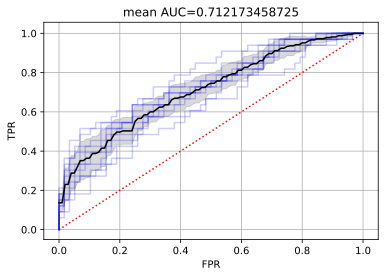

In [210]:
meanauc = plotROCs(allout)

The AUC of the baseline is 0.708 for the mortality task, and 0.713 for the treatment resistance task.

Fifth, put the data into a CSV file for submission to Kaggle.

In [211]:
write_csv_kaggle('mysub_baseline.csv', allout)

<hr>

The above classifier and feature set should be enough to get you started. You can try other classifiers or methods, as well as other features in the CSV file.  Note that some features are categorical, so some additional feature pre-processing might help.  Also, some features are time-series (labeled as "`M##_???`", where `##` are the month numbers (1-36).

A final note on the experiment setup: you shiould not select parameters by cross-validating across the 10 experiment trials, i.e., cross-validation should only be performed inside each experiment trial. Here we are interested in how well a particular method (including the parameter selection method) generalizes across different instances of the dataset.

# YOUR METHODS HERE

### Model with scalar features

In [212]:
dummyX = df['totno_antipsy'].values[:]
# print(dummyX)

varnames = ['Variable', 'Ignore', 'Label', 'Measure', 'Value Labels']

# extract data from dataframe (make a copy so we don't corrupt it later)
labelX = df_L_labels[varnames].values[:]
# for i in range(len(labelX)):
#     if(labelX[i][1]==0 and not(labelX[i][0][0] == 'M' and labelX[i][0][1] >= '0' and labelX[i][0][1] <= '9')):
#         print(labelX[i])
        
def istimeseries_label(labelname):
    if(labelname[1]==0 and not(labelname[0] == 'M' and labelname[1] >= '0' and labelname[1] <= '9')):
        return False

nontimeseries = [label for label in labelX if not istimeseries_label(label)]

In [213]:
nontimeseries[:len(nontimeseries)//20]

[array(['HCS_code', 0, 'HCS code (a=EI;b=SC)', 'Nominal', nan],
       dtype=object),
 array(['HCS10_code', 1, nan, 'Nominal', nan], dtype=object),
 array(['HCS10_sample', 1, nan, 'Nominal', "{0: 'No', 1: 'Yes'}"],
       dtype=object),
 array(['EASYp_code', 1, 'P code (EASY only)', 'Nominal', nan],
       dtype=object),
 array(['Sex', 0, 'Gender', 'Nominal', "{1: 'Male', 2: 'Female'}"],
       dtype=object),
 array(['Matched_pair', 1, 'Pair No.', 'Scale', nan], dtype=object),
 array(['Yr10_FU', 1, 'Date of 10-year in service', 'Scale', nan],
       dtype=object),
 array(['Yr10_sample', 1,
        '10-year FU sample (criteria date, dx, not deceased)', 'Scale',
        "{0: 'No', 1: 'Yes'}"], dtype=object),
 array(['Filter', 1, 'EASY/Control Filter (0=SC; 1=EI)', 'Nominal',
        "{0: 'SC', 1: 'EI'}"], dtype=object),
 array(['Filter2', 1, 'EASY/Control Filter (0=EI; 1=SC)', 'Scale',
        "{0: 'EI', 1: 'SC'}"], dtype=object),
 array(['Ageat1stpre', 0, 'Age (at 1st presentation)', 'S

In [214]:
import math
df['High_occup_regroup'] = pd.to_numeric(df['High_occup_regroup'],errors='coerce')
sub_list = df['High_occup_regroup'].values[:]

df['Days_to_relapse'] = pd.to_numeric(df['Days_to_relapse'],errors='coerce')
for i in range(len(df)):
    if(math.isnan(df['Days_to_relapse'].iloc[i]) == True):
        df['Days_to_relapse'][i] = 0
sub_list = df['Days_to_relapse'].values[:]

df['DSH_attempt_count'] = pd.to_numeric(df['DSH_attempt_count'],errors='coerce')
sub_list = df['DSH_attempt_count'].values[:]
print(sub_list)

df['AD_dur'] = pd.to_numeric(df['AD_dur'],errors='coerce')
for i in range(len(df)):
    if(math.isnan(df['AD_dur'].iloc[i]) == True):
        df['AD_dur'][i] = 0
sub_list = df['AD_dur'].values[:]

print(sub_list)
df['BZ_dur'] = pd.to_numeric(df['BZ_dur'],errors='coerce')
for i in range(len(df)):
    if(math.isnan(df['BZ_dur'].iloc[i]) == True):
        df['BZ_dur'][i] = 0
sub_list = df['BZ_dur'].values[:]
print(sub_list)
df['MS_dur'] = pd.to_numeric(df['MS_dur'],errors='coerce')
for i in range(len(df)):
    if(math.isnan(df['MS_dur'].iloc[i]) == True):
        df['MS_dur'][i] = 0
sub_list = df['MS_dur'].values[:]
print(sub_list[:len(sub_list)//2])

/home/paroma/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[ 0.  3.  0.  0.  1.  0.  0.  0.  0.  0.  0.  4.  0.  2.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0. 10.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  2.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

/home/paroma/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

In [215]:
# names of features from baseline file (longitudinal data).
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count']

# extract data from dataframe (make a copy so we don't corrupt it later)
dataY = df['Y'].values[:]
dataX = df[featnames].values[:]
dataY.shape, dataX.shape

((455,), (455, 26))

In [216]:
def highermaxiter_lrclf(trainX, trainY, testX):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    # fill in the missing values with the most frequent entry
    imp = impute.SimpleImputer(missing_values=nan, strategy='most_frequent')
    trainXi = imp.fit_transform(trainX)
    testXi  = imp.transform(testX)
    
    # setup the LR classifier -- maximize AUC when doing the cross-validation
    cla = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1, 
                                           scoring='roc_auc', max_iter=800, verbose=False)
    # fit the classifier
    cla.fit(trainXi, trainY)
    
    # predict the scores, and return them
    testYscores = cla.predict_proba(testXi)[:,1]
    return(testYscores)

In [217]:
allout = run_cv_experiment(highermaxiter_lrclf, dataX)

*** CV 0: test auc = 0.677638453501
*** CV 1: test auc = 0.73197492163
*** CV 2: test auc = 0.804597701149
*** CV 3: test auc = 0.792580982236
*** CV 4: test auc = 0.73301985371
*** CV 5: test auc = 0.771159874608
*** CV 6: test auc = 0.693312434692
*** CV 7: test auc = 0.78631138976
*** CV 8: test auc = 0.793103448276
*** CV 9: test auc = 0.775339602926


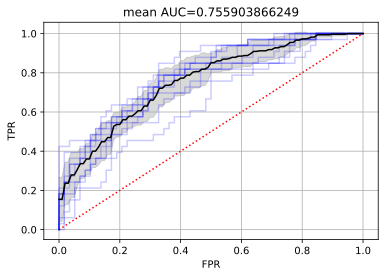

In [218]:
meanauc = plotROCs(allout)

In [219]:
write_csv_kaggle('baseline_featuresubset1.csv', allout)

### Preprocessing month timeseries columns

In [220]:
neg_symptoms_cols = [col for col in df if col.endswith("Pos")]

neg_symptoms_df = df[neg_symptoms_cols]
xr = [col[:-4] for col in neg_symptoms_cols]
xr = [int(col[1:]) for col in xr]


keyzip = zip(xr, neg_symptoms_cols)

keydict = {}
for key in keyzip:
    keydict[key[0]] = key[1]
    
print(keydict)

{1: 'M1_Pos', 2: 'M2_Pos', 3: 'M3_Pos', 4: 'M4_Pos', 5: 'M5_Pos', 6: 'M6_Pos', 7: 'M7_Pos', 8: 'M8_Pos', 9: 'M9_Pos', 10: 'M10_Pos', 11: 'M11_Pos', 12: 'M12_Pos', 13: 'M13_Pos', 14: 'M14_Pos', 15: 'M15_Pos', 16: 'M16_Pos', 17: 'M17_Pos', 18: 'M18_Pos', 19: 'M19_Pos', 20: 'M20_Pos', 21: 'M21_Pos', 22: 'M22_Pos', 23: 'M23_Pos', 24: 'M24_Pos', 25: 'M25_Pos', 26: 'M26_Pos', 27: 'M27_Pos', 28: 'M28_Pos', 29: 'M29_Pos', 30: 'M30_Pos', 31: 'M31_Pos', 32: 'M32_Pos', 33: 'M33_Pos', 34: 'M34_Pos', 35: 'M35_Pos', 36: 'M36_Pos'}


In [241]:
df_time = pd.DataFrame()

In [242]:
def label_race(row, label_root):
#     return len(row)
    timeseries_labels = ["M"+str(i)+"_{}".format(label_root) for i in range(1,37)]
    timeseries_vals = [row[label] for label in timeseries_labels]
    return timeseries_vals

In [243]:
x = df.apply(lambda x : label_race(x, "Neg"), axis=1)

#### Missing values :

In [244]:
print(x['CP001a'])
print()
print(x['SHUC242b'])

[2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 4.0, 2.0, 2.0, 1.0, nan, nan, nan]
()
[4.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [246]:
import re

r = re.compile('^(M[0-9]_|M[0-9][0-9]_)?')
mts_labels_list = [label for label in df if r.match(label)]
mts_labelroots_list = list(set(['_'.join(label.split("_")[1:]) for label in mts_labels_list]))

# print(mts_labelroots_list)


for label_root in mts_labelroots_list:
    df_time_label = "mts_{}".format(label_root)
#     print(df_time_label)
    try:
        df_time[df_time_label] = df.apply(lambda x : label_race(x, label_root), axis=1)
        print(df_time_label)
    except KeyError as e:
        pass

mts_AP2se
mts_V
mts_SOFAS
mts_ssca2
mts_ssca1
mts_hdose
mts_Meds2
mts_ssn
mts_ssd
mts_p4_ddd
mts_AP4se
mts_p1_ddd
mts_AP1se
mts_Meds
mts_AP3se
mts_Aff
mts_ssco1
mts_ssco2
mts_dsh
mts_ddd
mts_ect
mts_Negcf
mts_sle2
mts_Funct
mts_compliance
mts_hdose2
mts_sle1
mts_Funct_scorecf
mts_Neg
mts_comorbid
mts_timept2
mts_timept1
mts_SS
mts_Meds_r2
mts_ae
mts_default
mts_AP5se
mts_SOFAScf
mts_p3_ddd
mts_Funct_score
mts_IP
mts_Poscf
mts_Pos
mts_p2_ddd
mts_sa
mts_se


In [247]:
colslist = df_time.columns
print(sorted(colslist))

['mts_AP1se', 'mts_AP2se', 'mts_AP3se', 'mts_AP4se', 'mts_AP5se', 'mts_Aff', 'mts_Funct', 'mts_Funct_score', 'mts_Funct_scorecf', 'mts_IP', 'mts_Meds', 'mts_Meds2', 'mts_Meds_r2', 'mts_Neg', 'mts_Negcf', 'mts_Pos', 'mts_Poscf', 'mts_SOFAS', 'mts_SOFAScf', 'mts_SS', 'mts_V', 'mts_ae', 'mts_comorbid', 'mts_compliance', 'mts_ddd', 'mts_default', 'mts_dsh', 'mts_ect', 'mts_hdose', 'mts_hdose2', 'mts_p1_ddd', 'mts_p2_ddd', 'mts_p3_ddd', 'mts_p4_ddd', 'mts_sa', 'mts_se', 'mts_sle1', 'mts_sle2', 'mts_ssca1', 'mts_ssca2', 'mts_ssco1', 'mts_ssco2', 'mts_ssd', 'mts_ssn', 'mts_timept1', 'mts_timept2']


In [248]:
df_time

,mts_AP2se,mts_V,mts_SOFAS,mts_ssca2,mts_ssca1,mts_hdose,mts_Meds2,mts_ssn,mts_ssd,mts_p4_ddd,...,mts_AP5se,mts_SOFAScf,mts_p3_ddd,mts_Funct_score,mts_IP,mts_Poscf,mts_Pos,mts_p2_ddd,mts_sa,mts_se
HCS3,,,,,,,,,,,,,,,,,,,,,
CP001a,"[0.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[30, 40.0, 40.0, 40.0, 50.0, 70.0, 70.0, 70.0,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[01/01/1900, 01/01/1900, 01/01/1900, 01/01/190...","[0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[30, 40.0, 40.0, 40.0, 50.0, 70.0, 70.0, 70.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[7.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
CP001b,"[nan, 1, nan, nan, nan, nan, nan, nan, nan, na...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[50, 50.0, 30.0, 30.0, 30.0, 40.0, 30.0, 70.0,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[1.0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[01/01/1900, 01/01/1900, 01/01/1900, 01/01/190...","[0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[50, 50.0, 30.0, 30.0, 30.0, 40.0, 30.0, 70.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[5.0, 3.0, 3.0, 5.0, 3.0, 3.0, 1.0, 1.0, 1.0, ...","[5.0, 3.0, 3.0, 5.0, 3.0, 3.0, 1.0, 1.0, 1.0, ...","[0.0, 0.6666666666666666, 0, 0, 0, 0, 0, 0, 0,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
CP007a,"[0.0, 0, nan, nan, nan, nan, nan, nan, nan, na...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[30, 30.0, 40.0, 50.0, 50.0, 50.0, 50.0, 50.0,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[01/01/1900, 01/01/1900, 01/01/1900, 01/01/190...","[0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[30, 30.0, 40.0, 50.0, 50.0, 50.0, 50.0, 50.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5.0, 5.0, 5.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, ...","[5.0, 5.0, 5.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, ..."
CP011a,"[nan, 2, nan, nan, nan, nan, nan, nan, nan, na...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[60, 60.0, 60.0, 70.0, 70.0, 70.0, 70.0, 75.0,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1, 2, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[01/01/1900, 01/01/1900, 01/01/1900, 01/01/190...","[0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[60, 60.0, 60.0, 70.0, 70.0, 70.0, 70.0,

In [249]:
print(df_time['mts_SOFAS']['CP001a'])

[30, 40.0, 40.0, 40.0, 50.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 80.0, 80.0, 80.0, 80.0, 80.0, 30.0, 30.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, nan, nan, nan]


In [250]:
print(len(df_time.columns))
print(df_time.columns)

46
Index([u'mts_AP2se', u'mts_V', u'mts_SOFAS', u'mts_ssca2', u'mts_ssca1',
       u'mts_hdose', u'mts_Meds2', u'mts_ssn', u'mts_ssd', u'mts_p4_ddd',
       u'mts_AP4se', u'mts_p1_ddd', u'mts_AP1se', u'mts_Meds', u'mts_AP3se',
       u'mts_Aff', u'mts_ssco1', u'mts_ssco2', u'mts_dsh', u'mts_ddd',
       u'mts_ect', u'mts_Negcf', u'mts_sle2', u'mts_Funct', u'mts_compliance',
       u'mts_hdose2', u'mts_sle1', u'mts_Funct_scorecf', u'mts_Neg',
       u'mts_comorbid', u'mts_timept2', u'mts_timept1', u'mts_SS',
       u'mts_Meds_r2', u'mts_ae', u'mts_default', u'mts_AP5se', u'mts_SOFAScf',
       u'mts_p3_ddd', u'mts_Funct_score', u'mts_IP', u'mts_Poscf', u'mts_Pos',
       u'mts_p2_ddd', u'mts_sa', u'mts_se'],
      dtype='object')


##### Lots of nan values in some columns, so we try to fill in for them

In [251]:
### imputing missing integer/float values in an int/float 

def interpolate_ts(row, label):
    """
    given a row of a dataframe and a column label, apply linear interpolation on ts list for that column
    """
    ts_y = row[label]
    
    res = ts_y
    """
    x : array_like
    The x-coordinates at which to evaluate the interpolated values. (the x coordinates that are nan)
    """
    ts_x = [indx for indx in range(0,36) if math.isnan(ts_y[indx])]
    
    
    """
    xp : 1-D sequence of floats
    The x-coordinates of the data points, (indices of not nan)
    """
    ts_xp = [i for i in range(0, 36) if i not in ts_x]
    

    """
    fp : 1-D sequence of float or complex
    The y-coordinates of the data points (values that are not nan), same length as xp.
    """
    ts_y = [ts_y[i] for i in ts_xp]
    
    if len(ts_x) == 0:
        return ts_y
    else:
        interpolated_values =  interp(ts_x, ts_xp, ts_y)
        i = 0
        for nan_index in ts_x:
            res[nan_index] = interpolated_values[i]
            i+=1
        return res
        
    

In [252]:
# impute NaN values in mts_Pos column in dataframe
x = df_time.apply(lambda row: interpolate_ts(row, 'mts_Neg'), axis=1)

### check that the transformation has worked properly
counter=0
for dt in x:
    if len(dt) is not 36:
        print(dt)
        counter+=1
print(counter)


0


#### Replacing missing values

In [253]:
print(x['CP001a'])
print()
print(x['SHUC242b'])

[2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0]
()
[4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [254]:
df_time['mts_Neg'] = x

In [255]:
### Apply the same transformation to a few other columns
df_time['mts_Pos'] = df_time.apply(lambda row: interpolate_ts(row, 'mts_Pos'), axis=1)
df_time['mts_compliance'] = df_time.apply(lambda row: interpolate_ts(row, 'mts_compliance'), axis=1)

In [256]:
df_time['mts_SOFAS'] = df_time.apply(lambda row: interpolate_ts(row, 'mts_SOFAS'), axis=1)

In [257]:
df_time['mts_Aff'] = df_time.apply(lambda row: interpolate_ts(row, "mts_Aff"), axis=1 )

In [258]:
df_time['mts_Poscf'] = df_time.apply(lambda row: interpolate_ts(row, "mts_Poscf"), axis=1 )

In [259]:
df_time['mts_Funct_scorecf'] = df_time.apply(lambda row: interpolate_ts(row, "mts_Funct_scorecf"), axis=1 )

In [ ]:
# df_time['mts_dsh'] = df_time.apply(lambda row: interpolate_ts(row, "mts_dsh"), axis=1 )

In [262]:
df_time['mts_Funct'] = df_time.apply(lambda row: interpolate_ts(row, "mts_Funct"), axis=1 )

### Convert the timeseries into time series deltas

In [263]:
### define a delta function to do this
def makedeltas(row, label):
    ts = row[label]
    
    ## verify type is int or float
    for dt in ts:
        try:
            dt+=1
        except TypeError:
            print("Invalid data type for time series, returning original")
            return ts
        
    ### if it is, then run delta computation
    dts = []
    
    for i in range(1, len(ts)):
        delta = ts[i] - ts[i - 1]
        dts.append(delta)
    return dts
    
    

#### Pick selected columns to make deltas of 

In [264]:
df_time['dmts_Neg'] = df_time.apply(lambda row: makedeltas(row, "mts_Neg"), axis=1)

In [265]:
df_time['dmts_Pos'] = df_time.apply(lambda row: makedeltas(row, "mts_Pos"), axis=1)

In [266]:
df_time['dmts_compliance'] = df_time.apply(lambda row: makedeltas(row, "mts_compliance"), axis=1 )
df_time['dmts_SOFAS'] = df_time.apply(lambda row: makedeltas(row, "mts_SOFAS"), axis=1 )
df_time['dmts_Aff'] = df_time.apply(lambda row: makedeltas(row, "mts_Aff"), axis=1 )

In [270]:

df_time['dmts_Funct_scorecf'] =  df_time.apply(lambda row: makedeltas(row, "mts_Funct_scorecf"), axis=1 )
df_time['dmts_Funct'] =  df_time.apply(lambda row: makedeltas(row, "mts_Funct"), axis=1 )
df_time['dmts_Poscf'] =  df_time.apply(lambda row: makedeltas(row, "mts_Poscf"), axis=1 )


## try to encode the mts_sa (substance abuse) column as a bow

treat drug type as a word in the vocab

In [271]:
df_time['Y'] = df['Y']

### KNN classifiers using timeseries deltas 

This is a multivariate sequence classification problem. After some research, we think we should try some RNN-LSTM structure


A multivariate time series is a sequence of numerical
vectors. For example,

h(t1,h0.1, 0.3, 05i)(t2,h0.3, 0.9, 0.8i)···(tn,h0.3, 0.9, 0.4i)i

is a multivariate time series.

(https://www.cs.sfu.ca/~jpei/publications/Sequence%20Classification.pdf)

In [325]:
## try concatenating each of the timeseries into one feature vector, and finding distances between them using a BOW method
### might need to scale each time series list using a scaler

def concat_dts1(row):
    ts_mts_Neg = row['dmts_Neg']
    ts_mts_Pos = row['dmts_Pos']
    ts_mts_compliance = row['dmts_compliance']
    
    res = zeros((35, 3))
    for i in range(0, 35):
        res_i = asarray([ts_mts_Neg[i], \
                         ts_mts_Pos[i], \
                         ts_mts_compliance[i]])
        res[i,:] = res_i
        
    res = concatenate(res, axis=0)
    res = reshape(res, (35, 3))
    return res

def concat_dts2(row):
    ts_mts_Neg = row['dmts_Neg']
    ts_mts_Pos = row['dmts_Pos']
    ts_mts_compliance = row['dmts_compliance']
    
    res = zeros((35, 6))
    for i in range(0, 35):
        res_i = asarray([ts_mts_Neg[i], \
                         ts_mts_Pos[i], \
                         ts_mts_compliance[i],\
                         row['dmts_Funct_scorecf'][i],\
                         row['dmts_Funct'][i],\
                         row['dmts_Poscf'][i]])
        res[i,:] = res_i
        
    res = concatenate(res, axis=0)
    res = reshape(res, (35, 6))
    return res

In [326]:
df_time['d_tsfeatures_1'] = df_time.apply(lambda row : concat_dts1(row), axis=1) # compliance, neg, pos
df_time['d_tsfeatures_2'] = df_time.apply(lambda row : concat_dts2(row), axis=1) # compliance, neg, pos, Funct_scorecf, Funct, dmts_Poscf

In [327]:
print(shape(df_time['d_tsfeatures_1'][0]))
print(shape(df_time['d_tsfeatures_2'][0]))

(35, 3)
(35, 6)


In [330]:
# extract data from dataframe (make a copy so we don't corrupt it later)
dataY = df_time['Y'].values[:]

dataX1 = df_time['d_tsfeatures_1'].values
dataX1_list = dataX1.tolist()
dataX1_mat = stack(dataX1_list, axis=0)

dataX1 = dataX1_mat
print(shape(dataX1))

dataX2 = df_time['d_tsfeatures_2'].values
dataX2_list = dataX2.tolist()
dataX2_mat = stack(dataX2_list, axis=0)

dataX2 = dataX2_mat
print(shape(dataX2))

(455, 35, 3)
(455, 35, 6)


In [331]:
dataX1_reshaped = dataX1.reshape(455, 105)
print(dataX1_reshaped.shape)

dataX2_reshaped = dataX2.reshape(455, 210)
print(dataX2_reshaped.shape)

(455, 105)
(455, 210)


In [332]:
shape(dataX1_mat)

print(shape(dataX1_mat[0]), shape(dataX1_mat[1]))

from tslearn.metrics import dtw
dtw(dataX1_mat[0], dataX1_mat[2])

((35, 3), (35, 3))


7.635239027037726

In [333]:
shape(dataX2_mat)

print(shape(dataX2_mat[0]), shape(dataX2_mat[1]))

from tslearn.metrics import dtw
dtw(dataX2_mat[0], dataX2_mat[2])

((35, 6), (35, 6))


10.612492638395562

In [334]:
# print(dataX2_mat[0])
## Checking if reshaping the flattened input array will result in a the original multi-dimensional timeseries
temp1 = dataX2_mat[0]
flattened_temp1 = concatenate(dataX2_mat[0], axis=0)
temp2 = reshape(flattened_temp1, (35,6))
print(array_equal(temp1, temp2))

True


In [335]:
from sklearn.neighbors import KNeighborsClassifier

In [336]:
def knn_euclidean_clf_flattened(trainX, trainY, testX):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.

    neigh = KNeighborsClassifier(n_neighbors=int(len(trainX)/20))

#     fit the classifier
    neigh.fit(trainX, trainY)
    
    # predict the scores, and return them
    testYscores = neigh.predict_proba(testX)[:,1]
    return(testYscores)


*** CV 0: test auc = 0.579676071055
*** CV 1: test auc = 0.55303030303
*** CV 2: test auc = 0.565569487983
*** CV 3: test auc = 0.492946708464
*** CV 4: test auc = 0.527951933124
*** CV 5: test auc = 0.593260188088
*** CV 6: test auc = 0.491901776385
*** CV 7: test auc = 0.578108672936
*** CV 8: test auc = 0.573145245559
*** CV 9: test auc = 0.551724137931


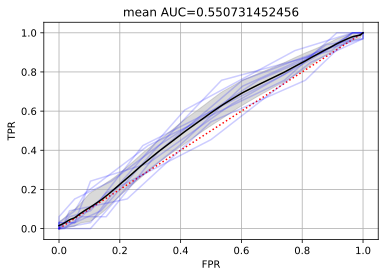

In [337]:
# run the experiment, and save the output
allout = run_cv_experiment(knn_euclidean_clf_flattened, dataX2_reshaped)
meanauc = plotROCs(allout)

We did not submit this one because performance was so bad.

In [338]:
write_csv_kaggle('knn_dtw_deltas_featuresubset2.csv', allout)

*** CV 0: test auc = 0.518808777429
*** CV 1: test auc = 0.478317659352
*** CV 2: test auc = 0.545977011494
*** CV 3: test auc = 0.44618599791
*** CV 4: test auc = 0.479885057471
*** CV 5: test auc = 0.538923719958
*** CV 6: test auc = 0.46473354232
*** CV 7: test auc = 0.502351097179
*** CV 8: test auc = 0.640020898642
*** CV 9: test auc = 0.576018808777


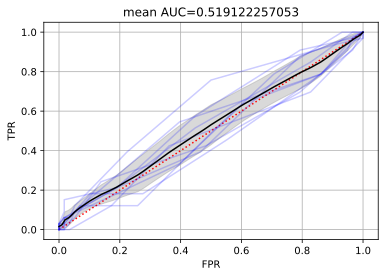

In [339]:
# run the experiment, and save the output
allout = run_cv_experiment(knn_euclidean_clf_flattened, dataX1_reshaped)
meanauc = plotROCs(allout)

In [340]:
write_csv_kaggle('knn_dtw_deltas_featuresubset1.csv', allout)

#### KNN using Dynamic Time Warping (timeseries deltas)

We still think edit distances are worth trying out when comparing time series features. On some research, we decide to try Dynamic Time Warping as an edit distance.

The only thing we add to the KNN-based classifier is changing the metric to use Dynamic Time Warping as an edit distance between multivariate time series. This gives a significant performance improvement over the simple Euclidean distance metric.

In [367]:
def sklearn_dtw_custom2(x, y):
    x_reshaped = reshape(x, (35, 6))
    y_reshaped = reshape(y, (35, 6))
    return dtw(x_reshaped, y_reshaped)

def sklearn_dtw_custom1(x, y):
    x_reshaped = reshape(x, (35, 3))
    y_reshaped = reshape(y, (35, 3))
    return dtw(x_reshaped, y_reshaped)

In [368]:
def knn_dtw_clf1(trainX, trainY, testX):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    neigh = nbrs = KNeighborsClassifier(n_neighbors=int(len(trainX)/30), algorithm='auto',
                       metric=sklearn_dtw_custom1)
    neigh.fit(trainX, trainY)
    # predict the scores, and return them
    testYscores = neigh.predict_proba(testX)[:,1]
    
    return(testYscores)

In [346]:
# run the experiment, and save the output
allout = run_cv_experiment(knn_dtw_clf1, dataX1_reshaped)

*** CV 0: test auc = 0.663793103448
*** CV 1: test auc = 0.566353187043
*** CV 2: test auc = 0.69696969697
*** CV 3: test auc = 0.691745036573
*** CV 4: test auc = 0.616509926855
*** CV 5: test auc = 0.62513061651
*** CV 6: test auc = 0.671368861024
*** CV 7: test auc = 0.609195402299
*** CV 8: test auc = 0.691745036573
*** CV 9: test auc = 0.658045977011


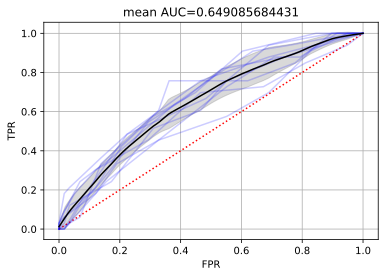

In [347]:
meanauc = plotROCs(allout)

In [349]:
write_csv_kaggle('knn_dtw_deltas_featuresubset1.csv', allout)

In [369]:
def knn_dtw_clf2(trainX, trainY, testX):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    neigh = nbrs = KNeighborsClassifier(n_neighbors=int(len(trainX)/30), algorithm='auto',
                       metric=sklearn_dtw_custom2)
    neigh.fit(trainX, trainY)
    # predict the scores, and return them
    testYscores = neigh.predict_proba(testX)[:,1]
    
    return(testYscores)

In [351]:
# run the experiment, and save the output
allout = run_cv_experiment(knn_dtw_clf2, dataX2_reshaped)

*** CV 0: test auc = 0.676593521421
*** CV 1: test auc = 0.62460815047
*** CV 2: test auc = 0.592737722048
*** CV 3: test auc = 0.659613375131
*** CV 4: test auc = 0.581243469175
*** CV 5: test auc = 0.591431556949
*** CV 6: test auc = 0.567920585162
*** CV 7: test auc = 0.592215256008
*** CV 8: test auc = 0.663531870428
*** CV 9: test auc = 0.644200626959


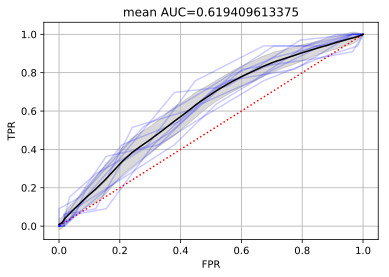

In [352]:
meanauc = plotROCs(allout)

Classifier performance is much better using the dtw distance metric on the timeseries deltas. However we do not submit this one because it is still not satisfactory

In [353]:
write_csv_kaggle('knn_dtw_deltas_featuresubset2.csv', allout)

### KNN on raw timeseries instead of deltas

Repeating the knn clustering approaches on the same timeseries observations (using the raw observations instead of computed deltas)

In [370]:
def concat_ts1(row):
    ts_mts_Neg = row['mts_Neg']
    ts_mts_Pos = row['mts_Pos']
    ts_mts_compliance = row['mts_compliance']
    
    res = zeros((36, 3))
    for i in range(0, 36):
        res_i = asarray([ts_mts_Neg[i], \
                         ts_mts_Pos[i], \
                         ts_mts_compliance[i]])
        res[i,:] = res_i
        
    res = concatenate(res, axis=0)
    res = reshape(res, (36, 3))
    return res

def concat_ts2(row):
    ts_mts_Neg = row['mts_Neg']
    ts_mts_Pos = row['mts_Pos']
    ts_mts_compliance = row['mts_compliance']
    
    res = zeros((36, 6))
    for i in range(0, 36):
        res_i = asarray([ts_mts_Neg[i], \
                         ts_mts_Pos[i], \
                         ts_mts_compliance[i],\
                         row['mts_Funct_scorecf'][i],\
                         row['mts_Funct'][i],\
                         row['mts_Poscf'][i]])
        res[i,:] = res_i
        
    res = concatenate(res, axis=0)
    res = reshape(res, (36, 6))
    return res

In [371]:
df_time['tsfeatures_1'] = df_time.apply(lambda row : concat_ts1(row), axis=1)
df_time['tsfeatures_2'] = df_time.apply(lambda row : concat_ts2(row), axis=1)

In [372]:
print(shape(df_time['tsfeatures_1'][0]))
print(shape(df_time['tsfeatures_2'][0]))

(36, 3)
(36, 6)


In [373]:
# extract data from dataframe (make a copy so we don't corrupt it later)
dataY = df_time['Y'].values[:]

dataX1 = df_time['tsfeatures_1'].values
dataX2 = df_time['tsfeatures_2'].values

dataX1_list = dataX1.tolist()
dataX2_list = dataX2.tolist()

dataX1_mat = stack(dataX1_list, axis=0)
dataX2_mat = stack(dataX2_list, axis=0)

dataX1 = dataX1_mat
dataX2 = dataX2_mat

print(shape(dataX1))
print(shape(dataX2))

(455, 36, 3)
(455, 36, 6)


In [374]:
dataX1_reshaped = dataX1.reshape(455, 108)
dataX2_reshaped = dataX2.reshape(455, 216)
print(dataX2_reshaped.shape)
print(dataX1_reshaped.shape)

(455, 216)
(455, 108)


#### KNN using Euclidean metric (raw timeseries features)

In [359]:
from sklearn.neighbors import KNeighborsClassifier

In [360]:
def knn_euclidean_clf_flattened(trainX, trainY, testX):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.

    neigh = KNeighborsClassifier(n_neighbors=int(len(trainX)/20))

#     fit the classifier
    neigh.fit(trainX, trainY)
    
    # predict the scores, and return them
    testYscores = neigh.predict_proba(testX)[:,1]
    return(testYscores)


*** CV 0: test auc = 0.701149425287
*** CV 1: test auc = 0.719696969697
*** CV 2: test auc = 0.782654127482
*** CV 3: test auc = 0.687826541275
*** CV 4: test auc = 0.606060606061
*** CV 5: test auc = 0.784221525601
*** CV 6: test auc = 0.686520376176
*** CV 7: test auc = 0.727011494253
*** CV 8: test auc = 0.687565308255
*** CV 9: test auc = 0.743469174504


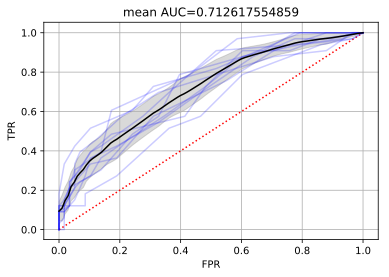

In [361]:
# run the experiment, and save the output

allout = run_cv_experiment(knn_euclidean_clf_flattened, dataX1_reshaped)
meanauc = plotROCs(allout)

In [362]:
write_csv_kaggle('knn_rawts_featuresubset1.csv', allout)

*** CV 0: test auc = 0.626436781609
*** CV 1: test auc = 0.725182863114
*** CV 2: test auc = 0.823928944619
*** CV 3: test auc = 0.697753396029
*** CV 4: test auc = 0.730668756531
*** CV 5: test auc = 0.737460815047
*** CV 6: test auc = 0.635841170324
*** CV 7: test auc = 0.692528735632
*** CV 8: test auc = 0.675287356322
*** CV 9: test auc = 0.730929989551


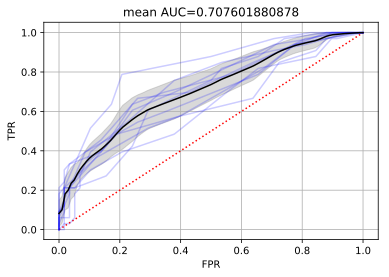

In [363]:
# run the experiment, and save the output

allout = run_cv_experiment(knn_euclidean_clf_flattened, dataX2_reshaped)
meanauc = plotROCs(allout)

Using the raw timeseries gives significantly better performance even with a Euclidean distance metric. We submit this to Kaggle.

In [364]:
write_csv_kaggle('knn_rawts_featuresubset2.csv', allout)

#### KNN using Dynamic Time Warping distance metric (raw timeseries features)

In [376]:
def sklearn_dtw_custom2(x, y):
    x_reshaped = reshape(x, (36, 6))
    y_reshaped = reshape(y, (36, 6))
    return dtw(x_reshaped, y_reshaped)

def sklearn_dtw_custom1(x, y):
    x_reshaped = reshape(x, (36, 3))
    y_reshaped = reshape(y, (36, 3))
    return dtw(x_reshaped, y_reshaped)

In [377]:
def knn_dtw_clf1(trainX, trainY, testX):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    neigh = nbrs = KNeighborsClassifier(n_neighbors=int(len(trainX)/30), algorithm='auto',
                       metric=sklearn_dtw_custom1)
    neigh.fit(trainX, trainY)
    # predict the scores, and return them
    testYscores = neigh.predict_proba(testX)[:,1]
    
    return(testYscores)

In [383]:
def knn_dtw_clf2(trainX, trainY, testX):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    neigh = nbrs = KNeighborsClassifier(n_neighbors=int(len(trainX)/30), algorithm='auto',
                       metric=sklearn_dtw_custom2)
    neigh.fit(trainX, trainY)
    # predict the scores, and return them
    testYscores = neigh.predict_proba(testX)[:,1]
    
    return(testYscores)

*** CV 0: test auc = 0.705067920585
*** CV 1: test auc = 0.726750261233
*** CV 2: test auc = 0.702978056426
*** CV 3: test auc = 0.608411703239
*** CV 4: test auc = 0.763845350052
*** CV 5: test auc = 0.704806687565
*** CV 6: test auc = 0.768808777429
*** CV 7: test auc = 0.700365726228
*** CV 8: test auc = 0.630094043887
*** CV 9: test auc = 0.715778474399


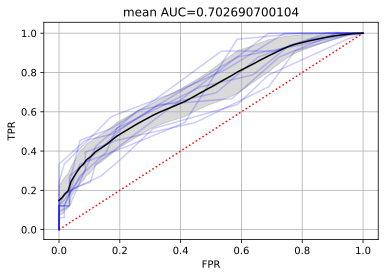

In [379]:
allout = run_cv_experiment(knn_dtw_clf1, dataX1_reshaped)
mean = plotROCs(allout)
write_csv_kaggle('knn_dtw_rawts_featuresubset1.csv', allout)

*** CV 0: test auc = 0.614681295716
*** CV 1: test auc = 0.779258098224
*** CV 2: test auc = 0.783437826541
*** CV 3: test auc = 0.682079414838
*** CV 4: test auc = 0.769853709509
*** CV 5: test auc = 0.728317659352
*** CV 6: test auc = 0.698014629049
*** CV 7: test auc = 0.706112852665
*** CV 8: test auc = 0.743469174504
*** CV 9: test auc = 0.716562173459


TypeError: 'numpy.float64' object is not callable

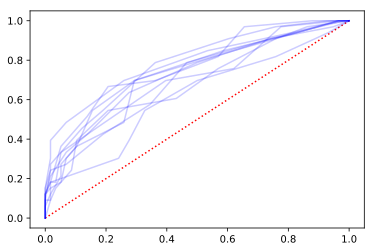

In [385]:
# run the experiment, and save the output
allout = run_cv_experiment(knn_dtw_clf2, dataX2_reshaped)
meanauc = plotROCs(allout)


The performance of this classifer is better than the one that used dtw with timeseries deltas. We submit this to Kaggle also.

In [386]:
write_csv_kaggle('knn_dtw_rawts_featuresubset2.csv', allout)

### Timeseries analysis using global features

#### Mean of raw timeseries features

In [168]:
def meanDeltas(row, label):
    ts = row[label]
    
    ## verify type is int or float
    for dt in ts:
        try:
            dt+=1
        except TypeError:
            print("Invalid data type for time series, returning original")
            return ts

    return mean(ts)

In [169]:
tsglobal_df['mean_mts_Neg'] = df_time.apply(lambda row: meanDeltas(row, "mts_Neg"), axis=1)
tsglobal_df['mean_mts_Pos'] = df_time.apply(lambda row: meanDeltas(row, "mts_Pos"), axis=1)
tsglobal_df['mean_mts_compliance'] = df_time.apply(lambda row: meanDeltas(row, "mts_compliance"), axis=1)
tsglobal_df['mean_mts_SOFAS'] = df_time.apply(lambda row: meanDeltas(row, "mts_SOFAS"), axis=1)
tsglobal_df['mean_mts_Aff'] = df_time.apply(lambda row: meanDeltas(row, "mts_Aff"), axis=1)

In [170]:
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count',
             'mean_mts_Pos','mean_mts_Neg','mean_mts_compliance','mean_mts_Aff']

dataX = tsglobal_df[featnames].values[:]
print(dataX.shape)

(455, 30)


*** CV 0: test auc = 0.677638453501
*** CV 1: test auc = 0.73197492163
*** CV 2: test auc = 0.804597701149
*** CV 3: test auc = 0.792580982236
*** CV 4: test auc = 0.73301985371
*** CV 5: test auc = 0.771159874608
*** CV 6: test auc = 0.693312434692
*** CV 7: test auc = 0.78631138976
*** CV 8: test auc = 0.793103448276
*** CV 9: test auc = 0.775339602926


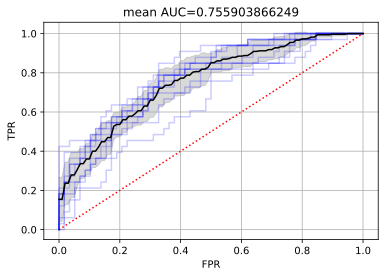

In [171]:
allout = run_cv_experiment(highermaxiter_lrclf, dataX)
meanauc = plotROCs(allout)

The mean of the selected raw timeseries features seems to give the best performance amongs all the global features. We will submit this to Kaggle.

In [172]:
write_csv_kaggle('scalars_with_mean_rawts1.csv', allout)

### Timeseries classification using global timeseries features 

#### Sum of deltas

Sum the deltas to get the trend, a more positive value means that there is an increase in this particular feature. If the sum is 0 patients are getting more resistant to the medication.

In [79]:
print(df_time['mts_Pos'][0])
print(df_time['mts_Neg'][1])
print(df_time['mts_compliance'][2])
print(df_time['mts_Pos'][3])

[7.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[5.0, 5.0, 4.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [80]:
def sumDeltas(row, label):
    ts = row[label]
    
    ## verify type is int or float
    for dt in ts:
        try:
            dt+=1
        except TypeError:
            print("Invalid data type for time series, returning original")
            return ts
        
    val = sum(ts)
    return val

In [134]:
tsglobal_df = pd.DataFrame()

In [135]:
tsglobal_df['sum_mts_Neg'] = df_time.apply(lambda row: sumDeltas(row, "dmts_Neg"), axis=1)
tsglobal_df['sum_mts_Pos'] = df_time.apply(lambda row: sumDeltas(row, "dmts_Pos"), axis=1)
tsglobal_df['sum_mts_compliance'] = df_time.apply(lambda row: sumDeltas(row, "dmts_compliance"), axis=1)
tsglobal_df['sum_mts_SOFAS'] = df_time.apply(lambda row: sumDeltas(row, "dmts_SOFAS"), axis=1)
tsglobal_df['sum_mts_Aff'] = df_time.apply(lambda row: sumDeltas(row, "dmts_Aff"), axis=1)

In [136]:
print(tsglobal_df['sum_mts_Pos'][0])
print(tsglobal_df['sum_mts_Neg'][1])
print(tsglobal_df['sum_mts_compliance'][2])
print(tsglobal_df['sum_mts_Pos'][3])

-6.0
-2.0
0.0
-4.0


In [83]:
print(df.shape)
print(df_time.shape)

(455, 2257)
(455, 52)


In [137]:
tsglobal_df = pd.concat([df.reset_index(drop=True),tsglobal_df.reset_index(drop=True)], axis=1)

In [138]:
print(tsglobal_df.shape)

(455, 2262)


In [139]:
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count',
             'sum_mts_Pos','sum_mts_Neg','sum_mts_compliance','sum_mts_Aff']

dataX = tsglobal_df[featnames].values[:]
print(dataX.shape)

(455, 30)


In [140]:
allout = run_cv_experiment(highermaxiter_lrclf, dataX)

*** CV 0: test auc = 0.69592476489
*** CV 1: test auc = 0.745559038662
*** CV 2: test auc = 0.815569487983
*** CV 3: test auc = 0.763845350052
*** CV 4: test auc = 0.741379310345
*** CV 5: test auc = 0.777429467085
*** CV 6: test auc = 0.700626959248
*** CV 7: test auc = 0.806687565308
*** CV 8: test auc = 0.765935214211
*** CV 9: test auc = 0.789446185998


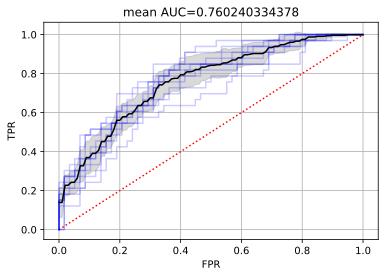

In [141]:
meanauc = plotROCs(allout)

In [142]:
write_csv_kaggle('test2_with_deltaSUM.csv', allout)

### Timeseries analysis using global features

#### Mean of deltas

In [143]:
def meanDeltas(row, label):
    ts = row[label]
    
    ## verify type is int or float
    for dt in ts:
        try:
            dt+=1
        except TypeError:
            print("Invalid data type for time series, returning original")
            return ts

    return mean(ts)

In [144]:
tsglobal_df['mean_dmts_Neg'] = df_time.apply(lambda row: meanDeltas(row, "dmts_Neg"), axis=1)
tsglobal_df['mean_dmts_Pos'] = df_time.apply(lambda row: meanDeltas(row, "dmts_Pos"), axis=1)
tsglobal_df['mean_dmts_compliance'] = df_time.apply(lambda row: meanDeltas(row, "dmts_compliance"), axis=1)
tsglobal_df['mean_dmts_SOFAS'] = df_time.apply(lambda row: meanDeltas(row, "dmts_SOFAS"), axis=1)
tsglobal_df['mean_dmts_Aff'] = df_time.apply(lambda row: meanDeltas(row, "dmts_Aff"), axis=1)

In [146]:
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count',
             'mean_dmts_Pos','mean_dmts_Neg','mean_dmts_compliance','mean_dmts_Aff']

dataX = tsglobal_df[featnames].values[:]
print(dataX.shape)

(455, 30)


*** CV 0: test auc = 0.677638453501
*** CV 1: test auc = 0.73197492163
*** CV 2: test auc = 0.804597701149
*** CV 3: test auc = 0.792580982236
*** CV 4: test auc = 0.73301985371
*** CV 5: test auc = 0.771159874608
*** CV 6: test auc = 0.693312434692
*** CV 7: test auc = 0.78631138976
*** CV 8: test auc = 0.793103448276
*** CV 9: test auc = 0.775339602926


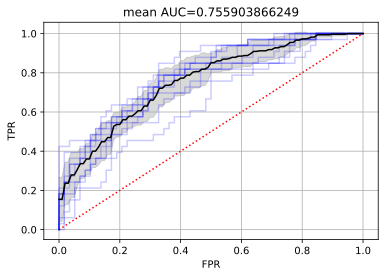

In [147]:
allout = run_cv_experiment(highermaxiter_lrclf, dataX)
meanauc = plotROCs(allout)

### Timeseries analysis using global features

#### Kurtosis of timeseries deltas

In [148]:
from scipy.stats import kurtosis

    
def kurtosisDeltas(row, label):
    ts = row[label]
    
    ## verify type is int or float
    for dt in ts:
        try:
            dt+=1
        except TypeError:
            print("Invalid data type for time series, returning original")
            return ts

    return kurtosis(ts)

In [149]:
tsglobal_df['kurtosis_dmts_Neg'] = df_time.apply(lambda row: kurtosisDeltas(row, "dmts_Neg"), axis=1)
tsglobal_df['kurtosis_dmts_Pos'] = df_time.apply(lambda row: kurtosisDeltas(row, "dmts_Pos"), axis=1)
tsglobal_df['kurtosis_dmts_compliance'] = df_time.apply(lambda row: kurtosisDeltas(row, "dmts_compliance"), axis=1)
tsglobal_df['kurtosis_dmts_SOFAS'] = df_time.apply(lambda row: kurtosisDeltas(row, "dmts_SOFAS"), axis=1)
tsglobal_df['kurtosis_dmts_Aff'] = df_time.apply(lambda row: kurtosisDeltas(row, "dmts_Aff"), axis=1)

In [152]:
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count',
             'kurtosis_dmts_Pos','kurtosis_dmts_Neg','kurtosis_dmts_compliance','kurtosis_dmts_Aff']

dataX = tsglobal_df[featnames].values[:]
print(dataX.shape)

(455, 30)


*** CV 0: test auc = 0.677638453501
*** CV 1: test auc = 0.73197492163
*** CV 2: test auc = 0.804597701149
*** CV 3: test auc = 0.792580982236
*** CV 4: test auc = 0.73301985371
*** CV 5: test auc = 0.771159874608
*** CV 6: test auc = 0.693312434692
*** CV 7: test auc = 0.78631138976
*** CV 8: test auc = 0.793103448276
*** CV 9: test auc = 0.775339602926


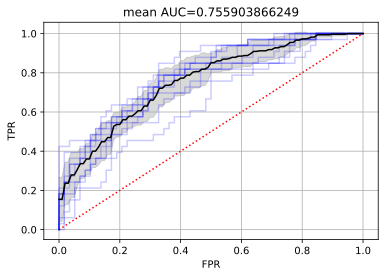

In [153]:
allout = run_cv_experiment(highermaxiter_lrclf, dataX)
meanauc = plotROCs(allout)

### Timeseries analysis using global features

#### Standard Deviation of raw timeseries features

In [154]:
from numpy import std
    
def sd_ts(row, label):
    ts = row[label]
    
    ## verify type is int or float
    for dt in ts:
        try:
            dt+=1
        except TypeError:
            print("Invalid data type for time series, returning original")
            return ts

    return std(ts)

In [155]:
tsglobal_df['sd_mts_Neg'] = df_time.apply(lambda row: sd_ts(row, "mts_Neg"), axis=1)
tsglobal_df['sd_mts_Pos'] = df_time.apply(lambda row: sd_ts(row, "mts_Pos"), axis=1)
tsglobal_df['sd_mts_compliance'] = df_time.apply(lambda row: sd_ts(row, "mts_compliance"), axis=1)
tsglobal_df['sd_mts_SOFAS'] = df_time.apply(lambda row: sd_ts(row, "mts_SOFAS"), axis=1)
tsglobal_df['sd_mts_Aff'] = df_time.apply(lambda row: sd_ts(row, "mts_Aff"), axis=1)

In [157]:
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count',
             'sd_mts_Pos','sd_mts_Neg','sd_mts_compliance','sd_mts_Aff']

dataX = tsglobal_df[featnames].values[:]
print(dataX.shape)

(455, 30)


*** CV 0: test auc = 0.677638453501
*** CV 1: test auc = 0.73197492163
*** CV 2: test auc = 0.804597701149
*** CV 3: test auc = 0.792580982236
*** CV 4: test auc = 0.73301985371
*** CV 5: test auc = 0.771159874608
*** CV 6: test auc = 0.693312434692
*** CV 7: test auc = 0.78631138976
*** CV 8: test auc = 0.793103448276
*** CV 9: test auc = 0.775339602926


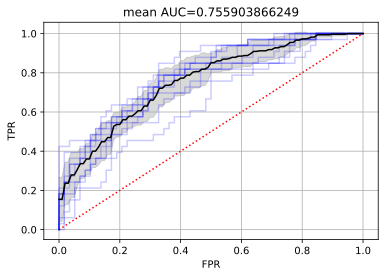

In [158]:
allout = run_cv_experiment(highermaxiter_lrclf, dataX)
meanauc = plotROCs(allout)

### Timeseries analysis using global features

#### Kurtosis of raw timeseries features

In [160]:
tsglobal_df['kurtosis_mts_Neg'] = df_time.apply(lambda row: kurtosisDeltas(row, "mts_Neg"), axis=1)
tsglobal_df['kurtosis_mts_Pos'] = df_time.apply(lambda row: kurtosisDeltas(row, "mts_Pos"), axis=1)
tsglobal_df['kurtosis_mts_compliance'] = df_time.apply(lambda row: kurtosisDeltas(row, "mts_compliance"), axis=1)
tsglobal_df['kurtosis_mts_SOFAS'] = df_time.apply(lambda row: kurtosisDeltas(row, "mts_SOFAS"), axis=1)
tsglobal_df['kurtosis_mts_Aff'] = df_time.apply(lambda row: kurtosisDeltas(row, "mts_Aff"), axis=1)

In [161]:
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count',
             'kurtosis_mts_Pos','kurtosis_mts_Neg','kurtosis_mts_compliance','kurtosis_mts_Aff']

dataX = tsglobal_df[featnames].values[:]
print(dataX.shape)

(455, 30)


*** CV 0: test auc = 0.677638453501
*** CV 1: test auc = 0.73197492163
*** CV 2: test auc = 0.804597701149
*** CV 3: test auc = 0.792580982236
*** CV 4: test auc = 0.73301985371
*** CV 5: test auc = 0.771159874608
*** CV 6: test auc = 0.693312434692
*** CV 7: test auc = 0.78631138976
*** CV 8: test auc = 0.793103448276
*** CV 9: test auc = 0.775339602926


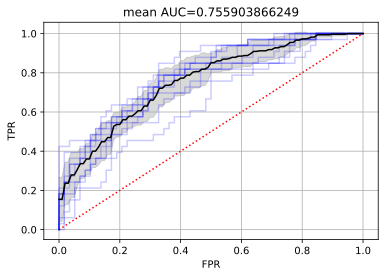

In [162]:
allout = run_cv_experiment(highermaxiter_lrclf, dataX)
meanauc = plotROCs(allout)

### Timeseries classifier 3

Same feature subset (including the summation of the deltas) but with a different end classifier.

We are trying the SVM classifier.

In [174]:
def mySVMclassifier(trainX, trainY, testX):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    # fill in the missing values with the most frequent entry
    imp = preprocessing.Imputer(missing_values=nan, strategy='most_frequent')
    trainXi = imp.fit_transform(trainX)
    testXi  = imp.transform(testX)
    
    # setup the SVM classifier -- maximize AUC when doing the cross-validation
    paramgrid ={'C': logspace(-2,3,10)}
    cla = model_selection.GridSearchCV(svm.SVC(kernel='linear'),paramgrid, cv = 5, scoring='roc_auc', n_jobs=-1)

    # fit the classifier
    cla.fit(trainXi, trainY)
    
    # predict the scores, and return them
    testYscores = cla.predict_proba(testXi)[:,1]
    return(testYscores)

### Timeseries classifier 4 (ensemble LSTM + LR classifier)

LSTM classifier for use with multivariate timeseries, and a LogisticRegression classifier for selected scalar features.

In [179]:
# use TensorFlow backend

%env KERAS_BACKEND=tensorflow     
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, Flatten, Input, LSTM
from keras.preprocessing.image import ImageDataGenerator
import keras

# select as appropriate
import tensorflow
import logging
import struct
import random
logging.basicConfig()
random.seed(4487)
tensorflow.set_random_seed(4487)

env: KERAS_BACKEND=tensorflow


In [180]:
## Function from course lecture notes
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'acc' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['acc'], 'b', label="training acc ({:.4f})".format(history.history['acc'][-1]))
        ax2.plot(history.history['val_acc'], 'b--', label="validation acc ({:.4f})".format(history.history['val_acc'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [181]:
# pass the classifier function clf and the data matrix X
# the function will automatically extract the training/test splits, 
# and then train and test the classifer.
def run_cv_experiment2(clf, X_lr, X_lstm):   
    # NOTE: uses dataY, test_inds, train_inds from calling scope since these don't change.
    
    T = len(test_inds[0])
    allout = []

    # run CV experiment
    for t in range(10):
        # get the training/testing data
        train_index = train_inds[t]
        test_index  = test_inds[t]
        trainX_lr = X_lr[train_index]
        trainX_lstm = X_lstm[train_index]
        trainY = dataY[train_index]
        testX_lr  = X_lr[test_index]
        testX_lstm  = X_lstm[test_index]
        testY  = dataY[test_index]
        
    
        # your function is called here!
        testYscores = clf(trainX_lstm,trainX_lr, trainY, testX_lstm,testX_lr)
         
        # compute ROC curve
        a = metrics.roc_auc_score(testY, testYscores)
        print("*** CV {}: test auc = {}".format(t, a))
    
        fpr, tpr, _ = metrics.roc_curve(testY, testYscores)
        aa = metrics.auc(fpr, tpr)  # it's the same as a
        #print(aa)
    
        # save info
        allout.append({
                'auc': a, 
                'fpr': fpr, 
                'tpr': tpr, 
                'testY': testY, 
                'testYscores': testYscores
            })
        
    # return all the information
    return(allout)

In [182]:
from sklearn.metrics import roc_curve
import ipdb
def LSTM_LR_classifier(trainX_LSTM, trainX_LR, trainY, testX_LSTM, testX_LR):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    # fill in the missing values with the most frequent entry
    imp = preprocessing.Imputer(missing_values=nan, strategy='most_frequent')
    trainXi = imp.fit_transform(trainX_LR)
    testXi  = imp.transform(testX_LR)
    
    # setup the nn -- maximize AUC when doing the cross-validation
    trainYb = keras.utils.np_utils.to_categorical(trainY)
    vtrainI, validI, vtrainYb, validYb = \
      model_selection.train_test_split(trainX_LSTM, trainYb, 
      train_size=0.9, test_size=0.1, random_state=4488)

    # make validation data
    validsetI = (validI, validYb)
    earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # look at the validation loss
    min_delta=0.0001,       # threshold to consider as no change
    patience=5,             # stop if 5 epochs with no change
    verbose=1, mode='auto')
    
    callbacks_list = [earlystop]
    nn = Sequential()
    nn.add(LSTM(150, input_shape=(len(trainX_LSTM[0]),len(trainX_LSTM[0][0])),recurrent_dropout=0.3,dropout=0.2,return_sequences=True))
    nn.add(Flatten())
    nn.add(Dense(units=2, activation='softmax'))
    nn.compile(loss = keras.losses.categorical_crossentropy, optimizer ='adam',metrics = ['accuracy'])
    history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size = 10,
                     callbacks=callbacks_list,validation_data=validsetI,verbose=False)
    y_pred_keras = nn.predict(testX_LSTM)[:,1]
    
    plot_history(history)
    
    # setup the LR classifier -- maximize AUC when doing the cross-validation
    cla = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1, 
                                           scoring='roc_auc')
    # fit the classifier
    cla.fit(trainXi, trainY)
    
    # predict the scores, and return them
    testYscores = cla.predict_proba(testXi)[:,1]
    for i in range(len(testYscores)):
        testYscores[i] = (testYscores[i]+y_pred_keras[i])/2
    return(testYscores)

/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00010: early stopping
*** CV 0: test auc = 0.717868338558


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00015: early stopping
*** CV 1: test auc = 0.738766980146


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00011: early stopping
*** CV 2: test auc = 0.78578892372


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00008: early stopping
*** CV 3: test auc = 0.790491118077


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00006: early stopping
*** CV 4: test auc = 0.761755485893


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00007: early stopping
*** CV 5: test auc = 0.818181818182


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00009: early stopping
*** CV 6: test auc = 0.740856844305


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00008: early stopping
*** CV 7: test auc = 0.790491118077


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00006: early stopping
*** CV 8: test auc = 0.734587251829


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00010: early stopping
*** CV 9: test auc = 0.797805642633


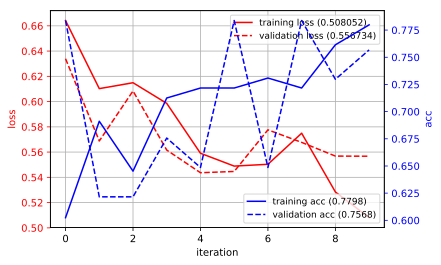

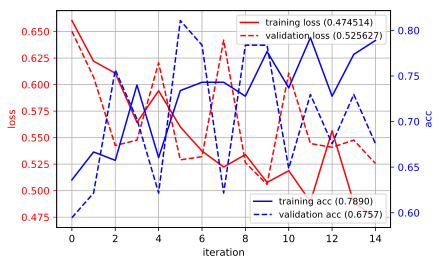

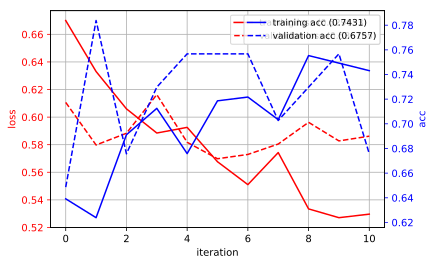

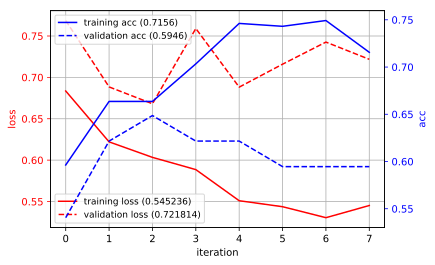

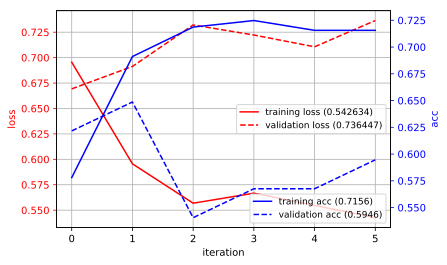

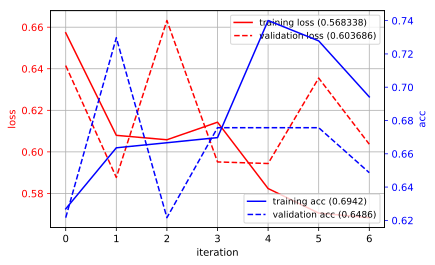

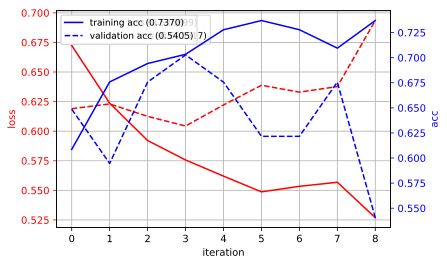

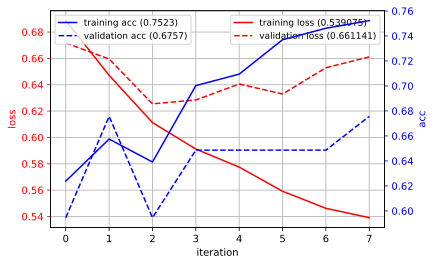

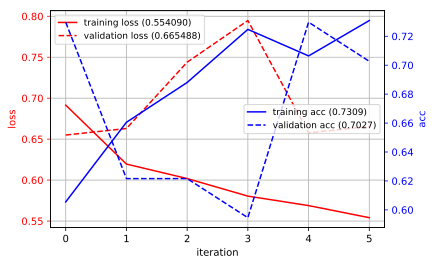

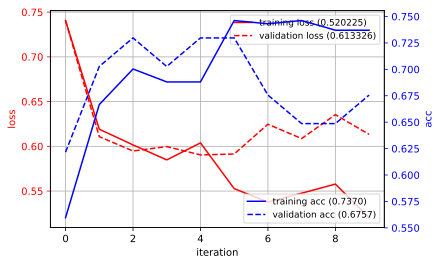

In [190]:
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count',
             'sum_mts_Pos','sum_mts_Neg','sum_mts_compliance','sum_mts_Aff']

featnames_lstm = ['mts_Pos','mts_Neg','mts_compliance','mts_Aff']
dataX_lr = tsglobal_df[featnames].values[:]
dataX_lstm = df_time[featnames_lstm].values[:]
dataX_list = dataX_lstm.tolist()
dataX_mat = stack(dataX_list, axis=0)
dataX_lstm = dataX_mat

allout = run_cv_experiment2(LSTM_LR_classifier, dataX_lr,dataX_lstm)

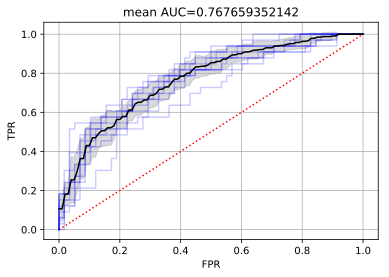

In [191]:
meanauc = plotROCs(allout)

In [192]:
write_csv_kaggle('test2_with_LR_and_LSTM.csv', allout)

In [193]:
from sklearn.metrics import roc_curve
import ipdb

def LSTM_LR_classifier(trainX_LSTM, trainX_LR, trainY, testX_LSTM, testX_LR):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    # fill in the missing values with the most frequent entry
    imp = preprocessing.Imputer(missing_values=nan, strategy='most_frequent')
    trainXi = imp.fit_transform(trainX_LR)
    testXi  = imp.transform(testX_LR)
    
    # setup the nn -- maximize AUC when doing the cross-validation
    trainYb = keras.utils.np_utils.to_categorical(trainY)
    vtrainI, validI, vtrainYb, validYb = \
      model_selection.train_test_split(trainX_LSTM, trainYb, 
      train_size=0.9, test_size=0.1, random_state=4488)

    # make validation data
    validsetI = (validI, validYb)
    earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # look at the validation loss
    min_delta=0.0001,       # threshold to consider as no change
    patience=5,             # stop if 5 epochs with no change
    verbose=1, mode='auto')
    
    callbacks_list = [earlystop]
    nn = Sequential()
    nn.add(LSTM(150, input_shape=(len(trainX_LSTM[0]),len(trainX_LSTM[0][0])),recurrent_dropout=0.3,dropout=0.2,return_sequences=True))
    nn.add(Flatten())
    nn.add(Dense(units=2, activation='softmax'))
    nn.compile(loss = keras.losses.categorical_crossentropy, optimizer ='adam',metrics = ['accuracy'])
    history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size = 10,
                     callbacks=callbacks_list,validation_data=validsetI,verbose=False)
    y_pred_keras = nn.predict(testX_LSTM)[:,1]
    
    plot_history(history)
    
    # setup the LR classifier -- maximize AUC when doing the cross-validation
    cla = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1, 
                                           scoring='roc_auc')
    # fit the classifier
    cla.fit(trainXi, trainY)
    
    # predict the scores, and return them
    testYscores = cla.predict_proba(testXi)[:,1]
    for i in range(len(testYscores)):
        testYscores[i] = (testYscores[i]+y_pred_keras[i])/2
    return(testYscores)

/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00014: early stopping
*** CV 0: test auc = 0.722048066876


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00012: early stopping
*** CV 1: test auc = 0.743991640543


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00016: early stopping
*** CV 2: test auc = 0.782654127482


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00009: early stopping
*** CV 3: test auc = 0.797805642633


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00007: early stopping
*** CV 4: test auc = 0.762800417973


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00018: early stopping
*** CV 5: test auc = 0.799373040752


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00010: early stopping
*** CV 6: test auc = 0.741379310345


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00008: early stopping
*** CV 7: test auc = 0.799895506792


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00008: early stopping
*** CV 8: test auc = 0.740856844305


/home/paroma/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 00011: early stopping
*** CV 9: test auc = 0.793625914316


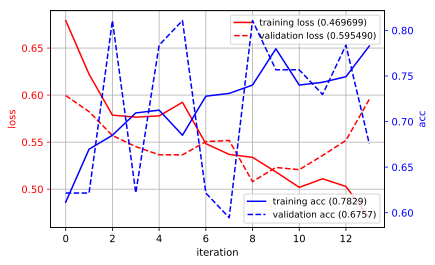

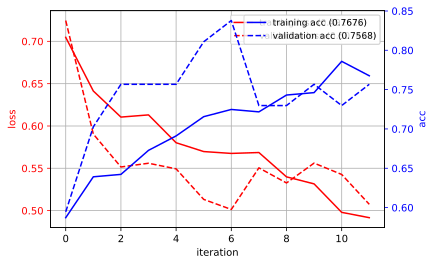

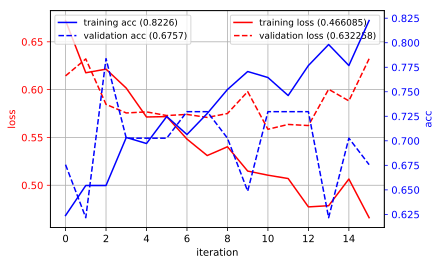

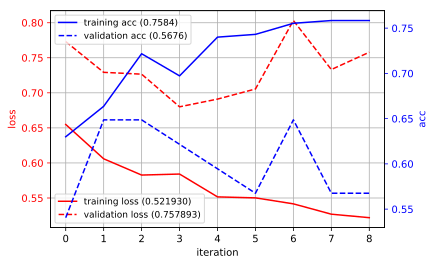

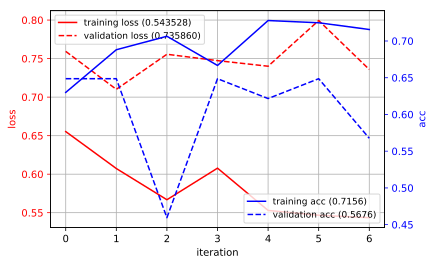

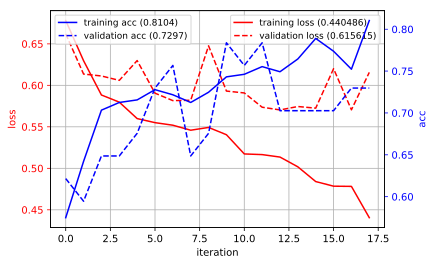

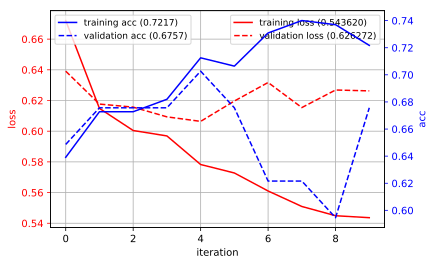

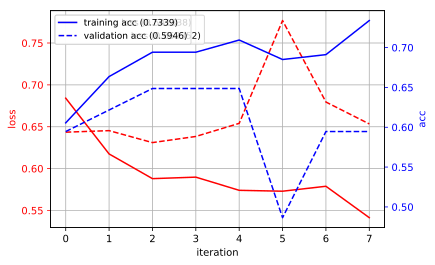

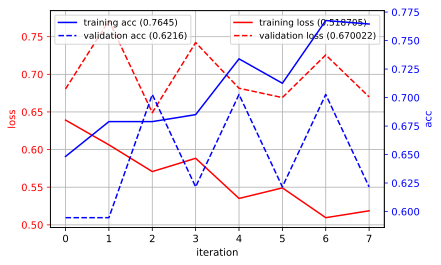

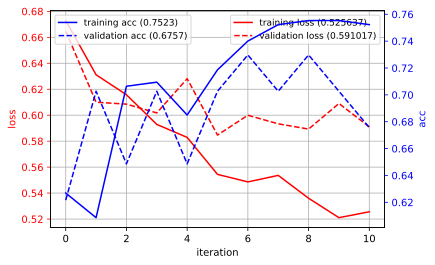

In [187]:
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count',
             'sum_mts_Pos','sum_mts_Neg','sum_mts_compliance','sum_mts_Aff']

featnames_lstm = ['mts_Pos','mts_Neg','mts_compliance','mts_Aff']
dataX_lr = new_df[featnames].values[:]
dataX_lstm = df_time[featnames_lstm].values[:]
dataX_list = dataX_lstm.tolist()

dataX_mat = stack(dataX_list, axis=0)
dataX_lstm = dataX_mat

allout = run_cv_experiment2(LSTM_LR_classifier, dataX_lr,dataX_lstm)

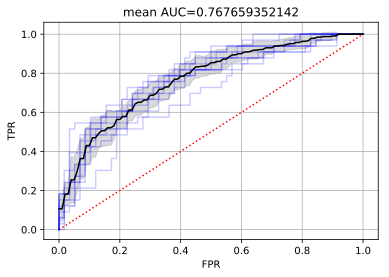

In [194]:
meanauc = plotROCs(allout)

In [195]:
write_csv_kaggle('test2_with_LR_and_LSTM.csv', allout)